In [123]:
from scipy.interpolate import interp1d

def soil_contourbydepth(df, df_depth, df_dz, start_time=None, end_time=None, 
                  depth_start=None, depth_end=None, n=100):
    '''
    data_path: path to output data to plot
    output_var: variable to plot (technically, doesn't need to be temperature)
    res: time resolution of output data
    px, py: pixel location of data
    output_folder: name of output folder
    start_time, end_time: start and end year of data to plot
    depth_start, depth_end: starting and ending depth to be plotted (in meters)
    n: levels on the colobar
    '''
#     df = interp_var
#     df_depth = depth
#     df_
#     df_depth, meta_depth = load_trsc_dataframe(var='LAYERDEPTH',  timeres=res, px_y=py, px_x=px, fileprefix=data_path+'/'+output_folder)
#     df_dz, meta_dzh = load_trsc_dataframe(var='LAYERDZ',  timeres=res, px_y=py, px_x=px, fileprefix=data_path+'/'+output_folder)
    
    layers = df.columns.astype(float)
    times = pd.to_datetime(df.index)
    
    # Filter data based on start_time and end_time
    if start_time is not None and end_time is not None:
        mask = (times >= start_time) & (times <= end_time)
        df = df.loc[mask]
        times = times[mask]

    # Extract necessary data
    depths = df_depth.iloc[:, :-2].values
    dz = df_dz.iloc[:, :-2].values
    temperature = df.iloc[:, :-2].values
    xp = depths + dz / 2  # Center of each layer, x-coordinates of the data points for interp1d

    # Create a regular grid of depth values
    ii=np.unravel_index(np.argmax(depths), depths.shape)
    maxd=depths.max()+(dz[ii]/2)
    regular_depths = np.arange(0, maxd, 0.01)

    # Interpolate temperature onto the regular grid
    interp_temperature = np.empty((temperature.shape[0], regular_depths.shape[0]))
    for i in range(temperature.shape[0]):
        f = interp1d(xp[i], temperature[i], kind='linear', fill_value='extrapolate')
        interp_temperature[i] = f(regular_depths)

    # Create contour plot
    color_axes = max(np.max(temperature), np.abs(np.min(temperature)))
    plt.contourf(times, regular_depths, interp_temperature.T, cmap='seismic', vmin=-color_axes, vmax=color_axes, levels=n)

    # Add colorbar
    plt.colorbar(label='Temperature (C)')

    # Set labels and title
    plt.xlabel('Time')
    plt.ylabel('Depth (m)')

    # Show the plot
    plt.ylim(depth_start, depth_end)
    plt.gca().invert_yaxis()
    return

In [134]:
# Importing dependencies
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0, '/work/scripts/util/')

from output import load_trsc_dataframe

# Setting directory structure

base_dir = "/data/workflows/latent_heat/"
f_dir = [
    "reference",
    "unfroz"
    ]
f_name = [
    "ref",
    "unfroz"  
    ]

In [135]:
# Importing variables

units = {}; monthly = {} ; yearly = {}

py = 0; px = 9

yearly_vars = ["ALD"]
monthly_vars = ['WATERTAB', 'SNOWTHICK']

layer_vars = ["LAYERDZ", "LAYERDEPTH", "LAYERTYPE", "LWCLAYER", "IWCLAYER", "TLAYER", "FRONTSDEPTH", "FRONTSTYPE"]
layer_data = {key: [] for key in layer_vars}
soil_vars = ["ground", "moss", "shlw", "deep", "mine"]
soil_profiles = {key: [] for key in soil_vars}

for i, DIR in enumerate(f_dir):
    
    df = pd.DataFrame() 
    
    for VAR in yearly_vars:
        
        dfa, meta = load_trsc_dataframe(var=VAR, timeres='yearly', px_y=py,
                                       px_x=px, fileprefix=f'{base_dir+DIR}/output')
        if dfa.columns.stop>1:
            dfa = pd.DataFrame(dfa.sum(axis=1))
        dfa.columns = [VAR];df = pd.concat([df,dfa], axis=1)
        
        if f_dir.index(DIR)==0:
            
            units[VAR]=meta['var_units']
        
    yearly[f_name[i]] = df
    
    df = pd.DataFrame()
    
    for VAR in monthly_vars:
        
        dfa, meta = load_trsc_dataframe(var=VAR, timeres='monthly', px_y=py,
                                       px_x=px, fileprefix=f'{base_dir+DIR}/output')
        if dfa.columns.stop>1:
            dfa = pd.DataFrame(dfa.sum(axis=1))
        dfa.columns = [VAR];df = pd.concat([df,dfa], axis=1)

        if f_dir.index(DIR)==0:
            
            units[VAR]=meta['var_units']
        
    monthly[f_name[i]] = df
    
    for VAR in layer_vars:
        
        dfa, meta = load_trsc_dataframe(var=VAR, timeres='monthly', px_y=py,
                                       px_x=px, fileprefix=f'{base_dir+DIR}/output')
        layer_data[VAR] += [dfa]

        if f_dir.index(DIR)==0:
            
            units[VAR]=meta['var_units']
            
    ground = layer_data["LAYERDEPTH"][i][0]        
    soil_profiles["ground"] += [pd.DataFrame({"ground":ground})]
    
    moss = ground - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==0], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["moss"] += [pd.DataFrame({"moss":moss})]
    
    shlw = moss - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==1], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["shlw"] += [pd.DataFrame({"shlw":shlw})]
    
    deep = shlw - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==2], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["deep"] += [pd.DataFrame({"deep":deep})]
    
    mine = deep - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==3], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["mine"] += [pd.DataFrame({"mine":mine})]

Trying to open:  /data/workflows/latent_heat/reference/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/latent_heat/reference/output/ALD_yearly_sc.nc
Trying to open:  /data/workflows/latent_heat/reference/output/WATERTAB_monthly_tr.nc
Trying to open:  /data/workflows/latent_heat/reference/output/WATERTAB_monthly_sc.nc
Trying to open:  /data/workflows/latent_heat/reference/output/SNOWTHICK_monthly_tr.nc
Trying to open:  /data/workflows/latent_heat/reference/output/SNOWTHICK_monthly_sc.nc
Trying to open:  /data/workflows/latent_heat/reference/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/latent_heat/reference/output/LAYERDZ_monthly_sc.nc
Trying to open:  /data/workflows/latent_heat/reference/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/latent_heat/reference/output/LAYERDEPTH_monthly_sc.nc
Trying to open:  /data/workflows/latent_heat/reference/output/LAYERTYPE_monthly_tr.nc
Trying to open:  /data/workflows/latent_heat/reference/output/LAYERTYPE_

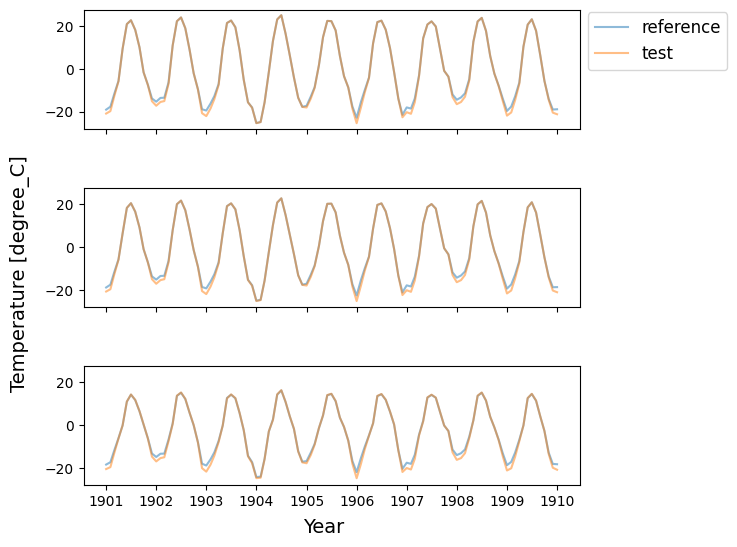

In [145]:
# Plotting temperature
n_layers = 3

date_start = pd.to_datetime("1901")
date_end = pd.to_datetime("1910")

fig, ax = plt.subplots(n_layers, 1, sharex=True, sharey=True)

for i in range(0, n_layers):
    
    ax[i].plot(layer_data["TLAYER"][0][date_start:date_end][i], alpha = 0.5, label="reference")
    ax[i].plot(layer_data["TLAYER"][1][date_start:date_end][i], alpha = 0.5, label="test")
    
ax[0].legend(bbox_to_anchor=(1.0, 1.05), loc="upper left", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.1, wspace=None, hspace=0.5)
fig.text(0.5, 0.01, 'Year', ha='center', fontsize=14)
fig.text(0.01, 0.55, f'Temperature [{units["TLAYER"]}]', va='center', rotation='vertical', fontsize=14)
plt.show()

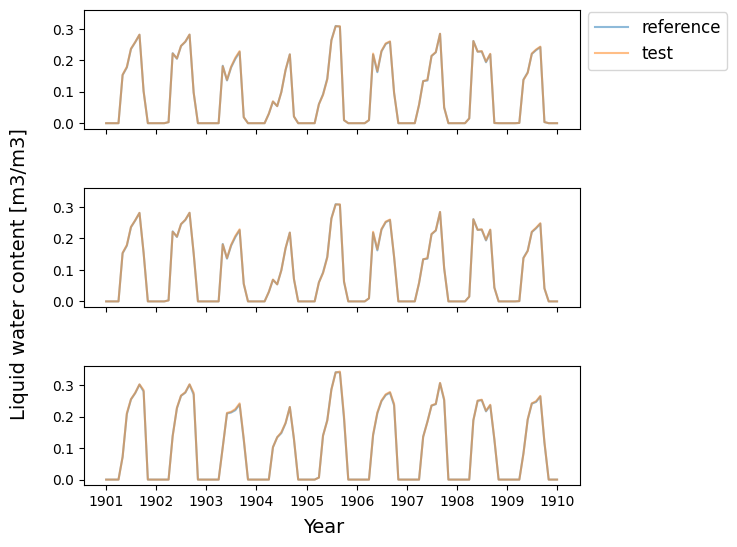

In [146]:
# Plotting liquid water
n_layers = 3

date_start = pd.to_datetime("1901")
date_end = pd.to_datetime("1910")

fig, ax = plt.subplots(n_layers, 1, sharex=True, sharey=True)

for i in range(0, n_layers):
    
    ax[i].plot(layer_data["LWCLAYER"][0][date_start:date_end][i], alpha = 0.5, label="reference")
    ax[i].plot(layer_data["LWCLAYER"][1][date_start:date_end][i], alpha = 0.5, label="test")
    
ax[0].legend(bbox_to_anchor=(1.0, 1.05), loc="upper left", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.1, wspace=None, hspace=0.5)
fig.text(0.5, 0.01, 'Year', ha='center', fontsize=14)
fig.text(0.01, 0.55, f'Liquid water content [{units["LWCLAYER"]}]', va='center', rotation='vertical', fontsize=14)
plt.show()

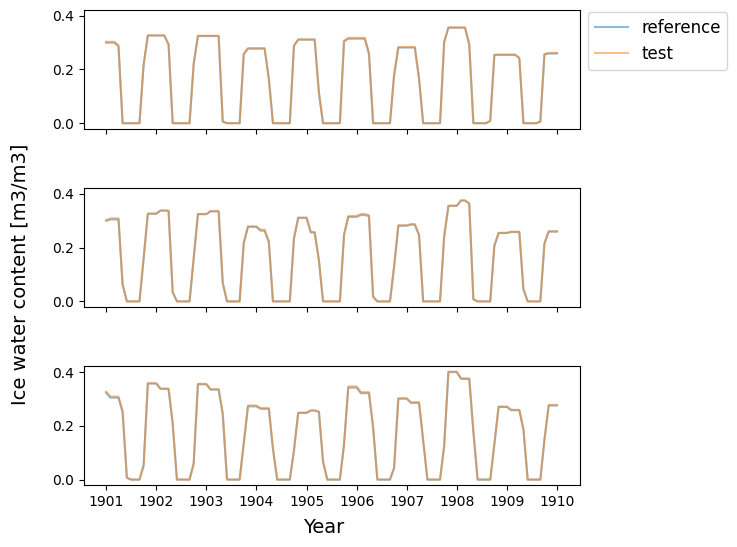

In [147]:
# Plotting ice water content
n_layers = 3

date_start = pd.to_datetime("1901")
date_end = pd.to_datetime("1910")

fig, ax = plt.subplots(n_layers, 1, sharex=True, sharey=True)

for i in range(0, n_layers):
    
    ax[i].plot(layer_data["IWCLAYER"][0][date_start:date_end][i], alpha = 0.5, label="reference")
    ax[i].plot(layer_data["IWCLAYER"][1][date_start:date_end][i], alpha = 0.5, label="test")
    
ax[0].legend(bbox_to_anchor=(1.0, 1.05), loc="upper left", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.1, wspace=None, hspace=0.5)
fig.text(0.5, 0.01, 'Year', ha='center', fontsize=14)
fig.text(0.01, 0.55, f'Ice water content [{units["IWCLAYER"]}]', va='center', rotation='vertical', fontsize=14)
plt.show()

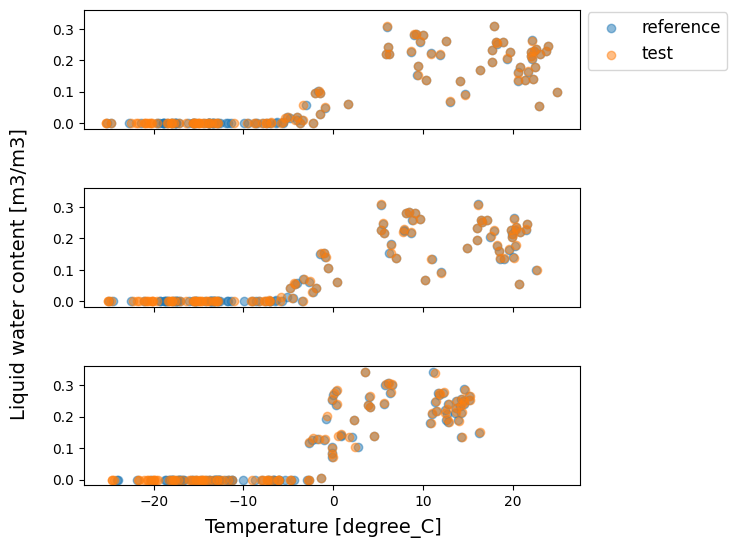

In [148]:
# Plotting liquid water against temperature
n_layers = 3

date_start = pd.to_datetime("1901")
date_end = pd.to_datetime("1910")

fig, ax = plt.subplots(n_layers, 1, sharex=True, sharey=True)

for i in range(0, n_layers):
    
    ax[i].scatter(layer_data["TLAYER"][0][date_start:date_end][i],layer_data["LWCLAYER"][0][date_start:date_end][i], alpha = 0.5, label="reference")
    ax[i].scatter(layer_data["TLAYER"][1][date_start:date_end][i], layer_data["LWCLAYER"][1][date_start:date_end][i], alpha = 0.5, label="test")
    
ax[0].legend(bbox_to_anchor=(1.0, 1.05), loc="upper left", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.1, wspace=None, hspace=0.5)
fig.text(0.5, 0.01, f"Temperature [{units['TLAYER']}]", ha='center', fontsize=14)
fig.text(0.01, 0.55, f'Liquid water content [{units["LWCLAYER"]}]', va='center', rotation='vertical', fontsize=14)
plt.show()

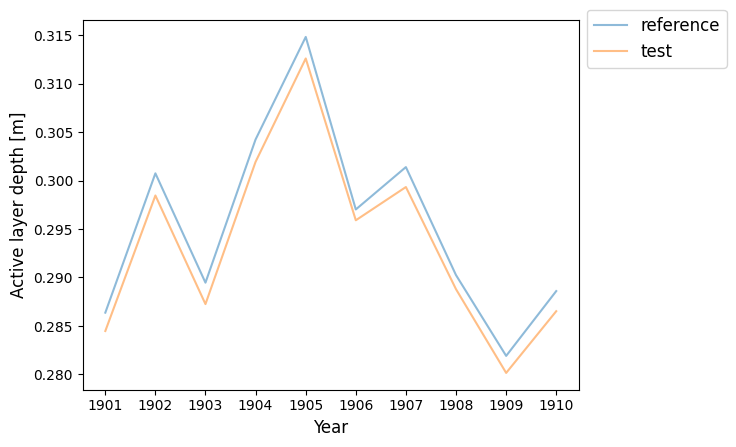

In [149]:
# Plotting active layer depth

date_start = pd.to_datetime("1901")
date_end = pd.to_datetime("1910")

plt.plot(yearly["ref"]["ALD"][date_start:date_end], alpha = 0.5, label="reference")
plt.plot(yearly["unfroz"]["ALD"][date_start:date_end], alpha = 0.5, label="test")
plt.legend(bbox_to_anchor=(1.0, 1.05), loc="upper left", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel(f"Active layer depth [{units['ALD']}]", fontsize=12)
plt.show()

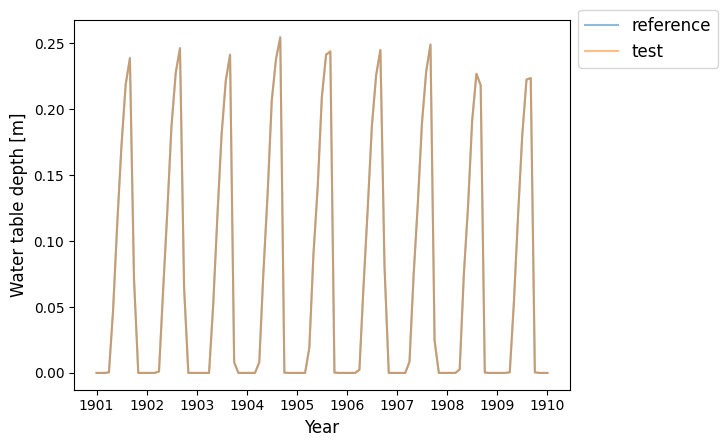

In [150]:
# Plotting water table depth

date_start = pd.to_datetime("1901")
date_end = pd.to_datetime("1910")

plt.plot(monthly["ref"]["WATERTAB"][date_start:date_end], alpha = 0.5, label="reference")
plt.plot(monthly["unfroz"]["WATERTAB"][date_start:date_end], alpha = 0.5, label="test")
plt.legend(bbox_to_anchor=(1.0, 1.05), loc="upper left", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel(f"Water table depth [{units['WATERTAB']}]", fontsize=12)
plt.show()

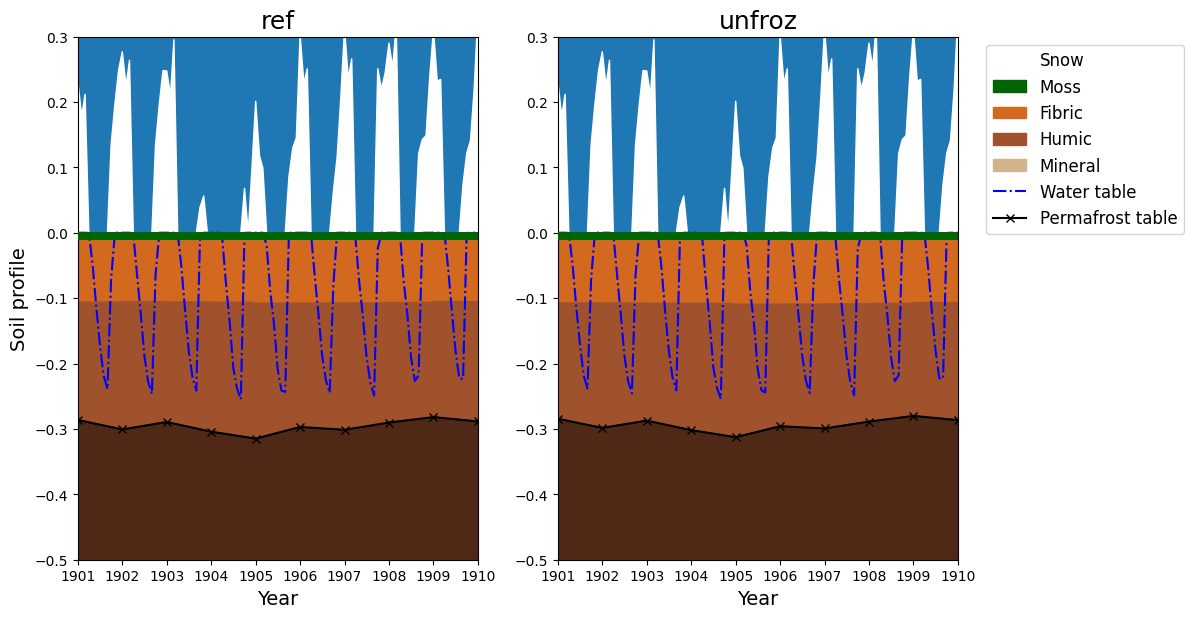

In [151]:
ymin = -0.5;  ymax = 0.3
xmin = pd.to_datetime("1901");  xmax = pd.to_datetime("1910")

fig, axis = plt.subplots(1, 2)

for i, run in enumerate(f_name):
    
    ax = axis[i]
        
    ax.set_facecolor('C0')
    
    ax.fill_between(monthly[run]["SNOWTHICK"].index, np.zeros(len(monthly[run]["SNOWTHICK"])), 
                    monthly[run]["SNOWTHICK"], color='white', label="Snow")
    
    ax.fill_between(soil_profiles["moss"][i].index, soil_profiles["moss"][i]["moss"], 
                    soil_profiles["ground"][i]["ground"],color="darkgreen", label='Moss', zorder=5)
    
    ax.fill_between(soil_profiles["shlw"][i].index, soil_profiles["shlw"][i]["shlw"], 
                    soil_profiles["moss"][i]["moss"],color="chocolate", label='Fibric')
    
    ax.fill_between(soil_profiles["deep"][i].index, soil_profiles["deep"][i]["deep"], 
                    soil_profiles["shlw"][i]["shlw"],color="sienna", label="Humic")
    
    ax.fill_between(soil_profiles["mine"][i].index, soil_profiles["mine"][i]["mine"], 
                    soil_profiles["deep"][i]["deep"],color="tan", label='Mineral')
    
    ax.plot(monthly[run]["WATERTAB"].index, -monthly[run]["WATERTAB"], 'b-.', label="Water table")
    
    ax.plot(yearly[run]["ALD"].index, -yearly[run]["ALD"], 'k-x', label="Permafrost table")
    ax.fill_between(yearly[run]["ALD"].index, -10 * np.ones(len(yearly[run]["ALD"])), -yearly[run]["ALD"], 
                    color='k', alpha=0.5)
    
#     ax.plot(layer_data["FRONTSDEPTH"][i][0].index, -layer_data["FRONTSDEPTH"][i].replace(-9999, np.nan), 'k')

    
    ax.set_title(f_name[i], fontsize=18)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Year', fontsize=14)
    if i == 0:
        ax.set_ylabel('Soil profile', fontsize=14)
    
    
        
handles, labels = plt.gca().get_legend_handles_labels()

ax.legend(handles=handles, bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=12)
        
plt.subplots_adjust(left=None, bottom=None, right=1.5, top=1.2, wspace=None, hspace=None)

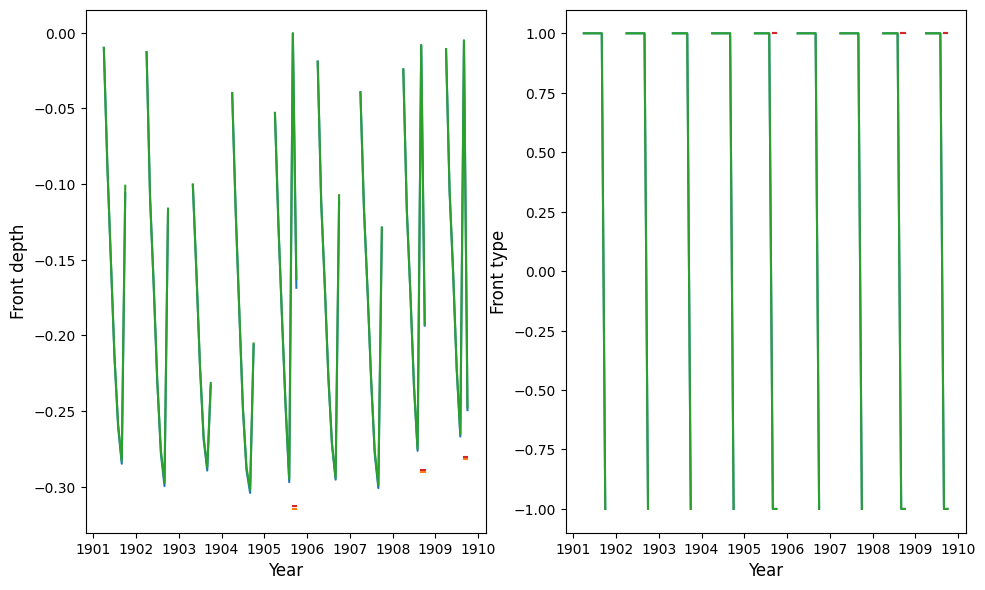

In [152]:
xmin = pd.to_datetime("1901");  xmax = pd.to_datetime("1910")

fig, ax = plt.subplots(1,2)

ax[0].plot(layer_data["FRONTSDEPTH"][0][0][xmin:xmax].index, -layer_data["FRONTSDEPTH"][0][xmin:xmax].replace(-9999, np.nan))
ax[1].plot(layer_data["FRONTSDEPTH"][0][0][xmin:xmax].index, -layer_data["FRONTSTYPE"][0][xmin:xmax].replace(-9999, np.nan))

ax[0].plot(layer_data["FRONTSDEPTH"][1][0][xmin:xmax].index, -layer_data["FRONTSDEPTH"][1][xmin:xmax].replace(-9999, np.nan))
ax[1].plot(layer_data["FRONTSDEPTH"][1][0][xmin:xmax].index, -layer_data["FRONTSTYPE"][1][xmin:xmax].replace(-9999, np.nan))

ax[0].set_xlabel("Year", fontsize=12); ax[1].set_xlabel("Year", fontsize=12)
ax[0].set_ylabel("Front depth", fontsize=12)
ax[1].set_ylabel("Front type", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=1.5, top=1.2, wspace=None, hspace=None)

plt.show()

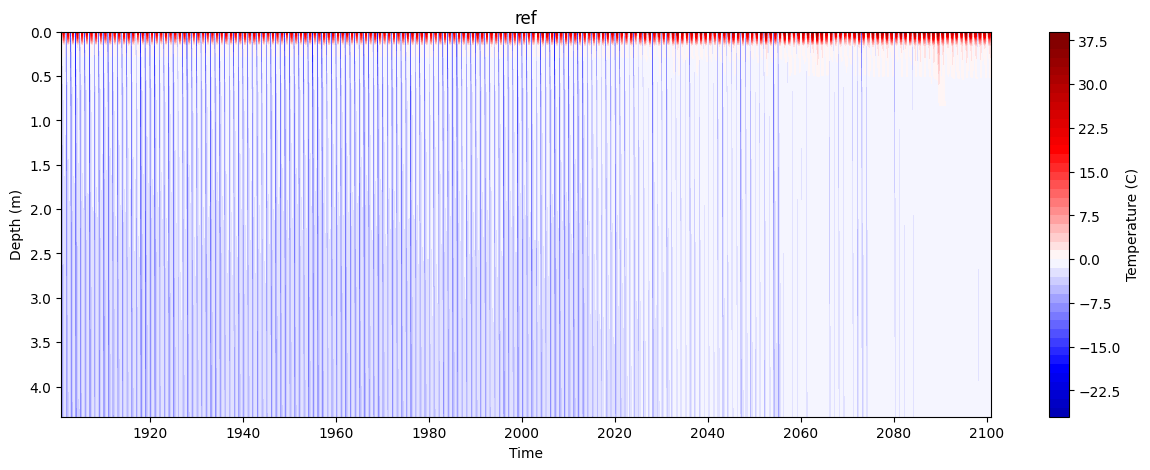

In [159]:
i = 0
fig, ax = plt.subplots(1,1,figsize=(15, 5))

soil_contourbydepth(
    
df = layer_data["TLAYER"][i],
    
df_depth = layer_data["LAYERDEPTH"][i],
    
df_dz = layer_data["LAYERDZ"][i],
    
start_time=None,
    
end_time=None,
    
depth_start=None, 
    
depth_end=None,
    
n=50
)

plt.title(f'{f_name[i]}')
plt.show()

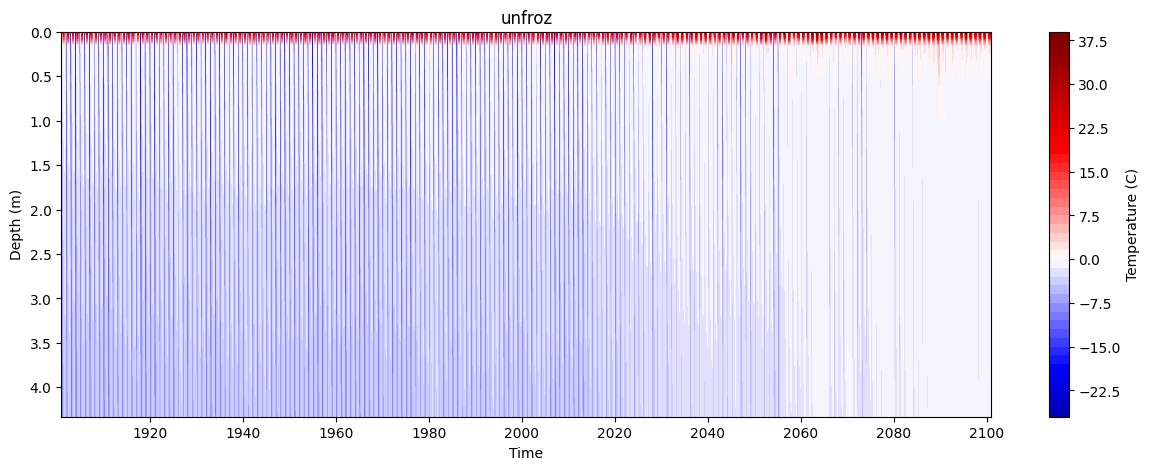

In [160]:
i = 1
fig, ax = plt.subplots(1,1,figsize=(15, 5))

soil_contourbydepth(
    
df = layer_data["TLAYER"][i],
    
df_depth = layer_data["LAYERDEPTH"][i],
    
df_dz = layer_data["LAYERDZ"][i],
    
start_time=None,
    
end_time=None,
    
depth_start=None, 
    
depth_end=None,
    
n=50
)

plt.title(f'{f_name[i]}')
plt.show()

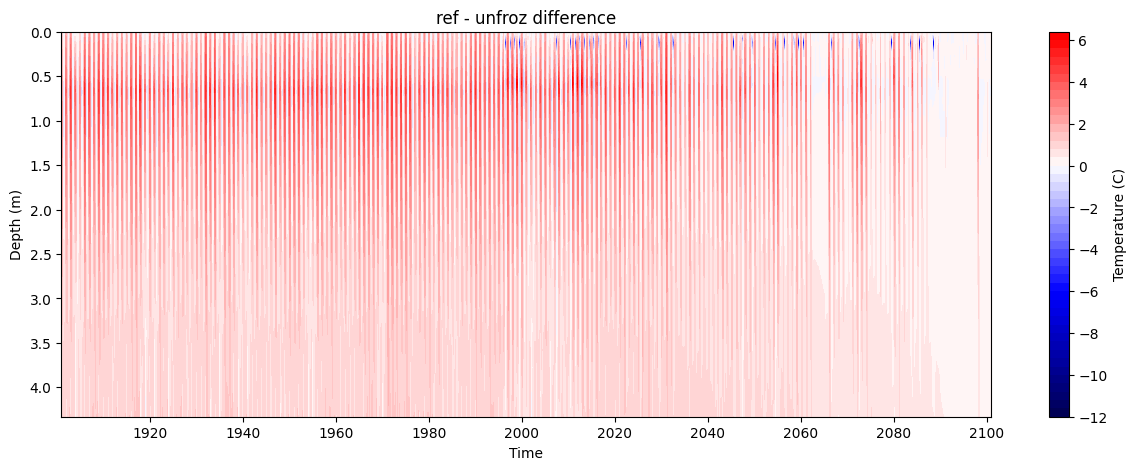

In [162]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))

soil_contourbydepth(
    
df = layer_data["TLAYER"][0] - layer_data["TLAYER"][1],
    
df_depth = (layer_data["LAYERDEPTH"][0] + layer_data["LAYERDEPTH"][1]) / 2,
    
df_dz = (layer_data["LAYERDZ"][0] + layer_data["LAYERDZ"][1]) / 2,
    
start_time=None,
    
end_time=None,
    
depth_start=None, 
    
depth_end=None,
    
n=50
)

plt.title(f'{f_name[0]} - {f_name[1]} difference')
plt.show()